In [413]:
import warnings
warnings.filterwarnings("ignore")

In [414]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as stat
import pandas as pd
from pandas.plotting import scatter_matrix
import scipy.stats as stats
import statsmodels.api as sm
import pandas.plotting as pd_plot
import scipy as sc
from pandas import DataFrame
import statsmodels.api as sm
from bioinfokit.analys import stat
import seaborn as sns


In [415]:
# modyfied equations from https://thequackdaddy.github.io/statsmodels.github.io/0.9.0/_modules/statsmodels/duration/survfunc.html
from scipy.stats import norm

def time_estimate(self, p):

    ii = np.flatnonzero(self.surv_times < p)
    
    if len(ii) == 0:
        return np.nan

    return self.surv_prob[len(ii)]

def time_estimate_ci(self, ptime, alpha=0.05, method='cloglog'):
        
        p  = time_estimate(self, ptime)
        p = 1 - p 
        tr = norm.ppf(1 - alpha / 2)

        method = method.lower()
        if method == "cloglog":
            g = lambda x: np.log(-np.log(x))
            gprime = lambda x: -1 / (x * np.log(x))
        elif method == "linear":
            g = lambda x: x
            gprime = lambda x: 1
        elif method == "log":
            g = lambda x: np.log(x)
            gprime = lambda x: 1 / x
        elif method == "logit":
            g = lambda x: np.log(x / (1 - x))
            gprime = lambda x: 1 / (x * (1 - x))
        elif method == "asinsqrt":
            g = lambda x: np.arcsin(np.sqrt(x))
            gprime = lambda x: 1 / (2 * np.sqrt(x) * np.sqrt(1 - x))
        else:
            raise ValueError("unknown method")

        r = g(self.surv_prob) - g(1 - p)
        r /= (gprime(self.surv_prob) * self.surv_prob_se)

        ii = np.flatnonzero(np.abs(r) <= tr)
        if len(ii) == 0:
            return np.nan, np.nan

        lb = self.surv_times[ii[0]]

        if ii[-1] == len(self.surv_times) - 1:
            ub = np.inf
        else:
            ub = self.surv_times[ii[-1] + 1]

        lb_time = time_estimate(self, lb)
        ub_time = time_estimate(self, ub)

        return lb_time, ub_time


## Exercise 8.1

The file meldates.dta contains the data on survival with malignant melanoma from the lecture
day 8. Below we will go through the analysis of these data in Stata. 

First we setup the data as survival data in Stata using time since operation (in years) as the time
scale. 
Or first we can calculate the time since operation
generate survtime=(enddate-startdat)/365.25
stset survtime, failure(status==1)
After this we can estimate the survival function and the cumulative mortality proportion by the
Kaplan-Meier method: 


#### 1. Look at the graph: What is the risk of dying within 7 years after the operation? Use the command sts list, at(0 7) fail to get the precise value.  Look at the graph: The 25-percentile of the time to death? Use the command stci, p(25) to get the precise value. We will now compare the mortality among men and women.

#### 2. Plot the survival function for men and women separately. Find the 25-percentile of the time to death for men and women. Compare survival for men and women using the log-rank test. 


In [416]:
meldates = pd.read_csv('data/meldates.csv', sep=',', decimal=".")

In [454]:
# calculating the survival in years

from datetime import date, datetime

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

list_diff = []
for i in range(0, len(meldates)):
    date_diff = (datetime(np.int(meldates['enddate'][i][5:]), 
                                  months.index(meldates['enddate'][i][2:5]) + 1, 
                                  np.int(meldates['enddate'][i][0:2])) - 
                 datetime(np.int(meldates['startdate'][i][5:]), 
                                  months.index(meldates['startdate'][i][2:5]) + 1, 
                                  np.int(meldates['startdate'][i][0:2])))
    list_diff.append(date_diff.days/365.25)
    
meldates['surv_yrs'] = list_diff
meldates['bin_status'] = 1
meldates['bin_status'][meldates['status'] == 'censored'] = 0


In [455]:
meldates_f = meldates.loc[meldates.sex == "female", :]
sfem = sm.SurvfuncRight(meldates_f['surv_yrs'], meldates_f['bin_status'])
sfem.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
0.763860,0.991935,0.008032,124,1.0
0.807666,0.983871,0.011313,123,1.0
1.056810,0.975740,0.013836,121,1.0
1.284052,0.967609,0.015932,120,1.0
1.826146,0.959477,0.017752,119,1.0


In [456]:
meldates_m = meldates.loc[meldates.sex == "male", :]
smale = sm.SurvfuncRight(meldates_m['surv_yrs'], meldates_m['bin_status'])
smale.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
0.506502,0.986842,0.013071,76,1.0
0.558522,0.973684,0.018362,75,1.0
0.574949,0.960526,0.022336,74,1.0
0.635181,0.947368,0.025614,73,1.0
1.166324,0.934211,0.028438,72,1.0


Text(0.5, 0, 'Years since operation')

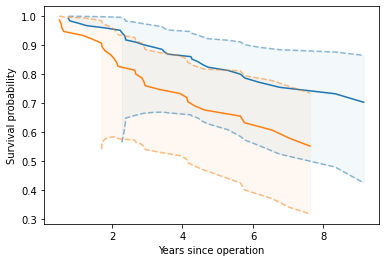

In [457]:
# Plotting the survival curves for men and women

gb = meldates.groupby("sex")
ax = plt.axes()
sexes = []
col = ['C0', 'C1']
i = 0
for g in gb:
    sexes.append(g[0])
    sf = sm.SurvfuncRight(g[1]["surv_yrs"], g[1]["bin_status"])
    #sf.plot(ax)

    lcb, ucb = sf.simultaneous_cb()
    #lcb = np.array(1/lcb)
    #ucb = np.array(1/ucb)
    
    #lcb[np.isnan(lcb)] = 0
    #ucb[np.isnan(ucb)] = 0
    #lcb[np.isinf(lcb)] = 0
    #ucb[np.isinf(ucb)] = 0
    
    ax.fill_between(sf.surv_times[:], sf.surv_prob[:], ucb[:], alpha=0.05, color=col[i])
    ax.fill_between(sf.surv_times[6:], lcb[6:],sf.surv_prob[6:], alpha=0.05, color=col[i])

    ax.plot(sf.surv_times[6:], lcb[6:], alpha=0.5, color=col[i], linestyle='--')
    ax.plot(sf.surv_times[:], ucb[:], alpha=0.5, color=col[i], linestyle='--')

    ax.plot(sf.surv_times, sf.surv_prob)
    i = i + 1
    
ax.set_ylabel("Survival probability")
ax.set_xlabel("Years since operation")

In [458]:
print('### Male group ####################################')

#print('\n Risk of dying within 7 years after the operation:', 1-np.float(time_estimate(smale, 7)), 
#'95% CI: ', 1-np.array(time_estimate_ci(smale, 7)))

print('\n 25-percentile of the time to death: ', smale.quantile(0.25), 
      '95% CI:', smale.quantile_ci(0.25))

print('\n \n')
print('### Female group ####################################')

#print('\n Risk of dying within 7 years after the operation:', 1-np.float(time_estimate(sfem, 7)), 
#      '95% CI: ', 1-np.array(time_estimate_ci(sfem, 7)))

print('\n 25-percentile of the time to death: ', sfem.quantile(0.25), 
      '95% CI:', sfem.quantile_ci(0.25))

### Male group ####################################

 25-percentile of the time to death:  3.36208076659822 95% CI: (2.132785763175907, 5.757700205338809)

 

### Female group ####################################

 25-percentile of the time to death:  8.328542094455852 95% CI: (4.725530458590007, inf)


In [459]:
# Perfoming a log-rank test (to conpare the two survival distributions)
stat, pv = sm.duration.survdiff(meldates['surv_yrs'], meldates['bin_status'], meldates['sex'])

print('Log-rank test: ', 'Chi-squared:', stat, '. p-value: ', pv)

Log-rank test:  Chi-squared: 6.4679768573416005 . p-value:  0.010983549936573911


P-value = 0.01 -> there is a statistically significant difference between the survival of male and female groups.

### 3. Check the validity of the assumption of proportional hazards by making (A) the observed and fitted survival curves; (B) the log-minus-log survival curves:

Text(0.5, 0, 'Years since operation')

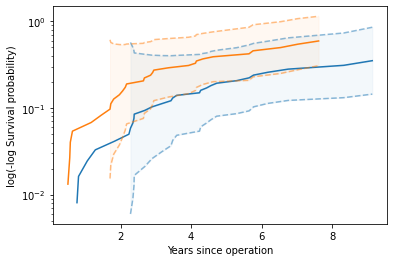

In [463]:
# Plotting the survival curves for men and women

gb = meldates.groupby("sex")
ax = plt.axes()
sexes = []
col = ['C0', 'C1']
i = 0
for g in gb:
    sexes.append(g[0])
    sf = sm.SurvfuncRight(g[1]["surv_yrs"], g[1]["bin_status"])
    #sf.plot(ax)

    lcb, ucb = sf.simultaneous_cb()
    #lcb = np.array(1/lcb)
    #ucb = np.array(1/ucb)
    
    #lcb[np.isnan(lcb)] = 0
    #ucb[np.isnan(ucb)] = 0
    #lcb[np.isinf(lcb)] = 0
    #ucb[np.isinf(ucb)] = 0
    
    ax.fill_between(sf.surv_times[6:], -np.log(sf.surv_prob[6:]), -np.log(ucb[6:]), alpha=0.05, color=col[i])
    ax.fill_between(sf.surv_times[6:], -np.log(lcb[6:]), -np.log(sf.surv_prob[6:]), alpha=0.05, color=col[i])
    
    ax.plot(sf.surv_times[6:], -np.log(lcb[6:]), color=col[i], linestyle='--', alpha=0.5)
    ax.plot(sf.surv_times[6:], -np.log(ucb[6:]), color=col[i], linestyle='--', alpha=0.5)
    
    ax.plot(sf.surv_times, -np.log(sf.surv_prob))
    i = i + 1
    
plt.yscale('log')
#plt.ylim([1, 110])
ax.set_ylabel("log(-log Survival probability)")
ax.set_xlabel("Years since operation")

#### Is it reasonable to assume that the hazard ratio is constant over time?

I wouldn't say so, as the log-log survival probability increases with time.

#### Finally we can estimate the log hazard ratio and the hazard ratio:

In [462]:
meldates['bin_sex'] = 1
meldates['bin_sex'][meldates['sex'] == 'male'] = 0

mod = smf.phreg("surv_yrs ~ bin_sex + bin_status",
                meldates, status='bin_status', ties="efron")

rslt = mod.fit()
print(rslt.summary())

                                Results: PHReg
Model:                          PH Reg              Sample size:            201
Dependent variable:             surv_yrs            Num. events:            57 
Ties:                           Efron                                          
-------------------------------------------------------------------------------
            log HR  log HR SE           HR            t    P>|t|  [0.025 0.975]
-------------------------------------------------------------------------------
bin_sex    -0.3490      0.2710              0.7054 -1.2881 0.1977 0.4147 1.1997
bin_status 31.9592 449838.1982 75804011520290.0938  0.0001 0.9999 0.0000    inf
Confidence intervals are for the hazard ratios


### 4. Find the hazard ratio comparing males to females, and present an interpretation of the hazard ratio

AttributeError: 'PHReg' object has no attribute 'surv_times'

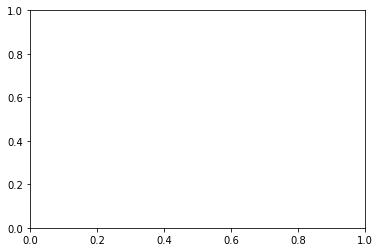

In [466]:
# Plotting the survival curves for men and women

gb = meldates.groupby("sex")
ax = plt.axes()
sexes = []
col = ['C0', 'C1']
i = 0
for g in gb:
    sexes.append(g[0])
    sf = smf.phreg("surv_yrs ~ bin_sex + bin_status",
                meldates, status='bin_status', ties="efron")
    print(sf)
    #sf.plot(ax)

    #lcb, ucb = sf.simultaneous_cb()
    #lcb = np.array(1/lcb)
    #ucb = np.array(1/ucb)
    
    #lcb[np.isnan(lcb)] = 0
    #ucb[np.isnan(ucb)] = 0
    #lcb[np.isinf(lcb)] = 0
    #ucb[np.isinf(ucb)] = 0

    ax.plot(sf.surv_times, -np.log(sf.surv_prob))
    i = i + 1
    
plt.yscale('log')
#plt.ylim([1, 110])
ax.set_ylabel("log(-log Survival probability)")
ax.set_xlabel("Years since operation")